In [1]:
import pandas as pd
import numpy as np

housing = pd.read_csv("_datasets/housing.csv")

In [2]:
len(housing)


20640

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



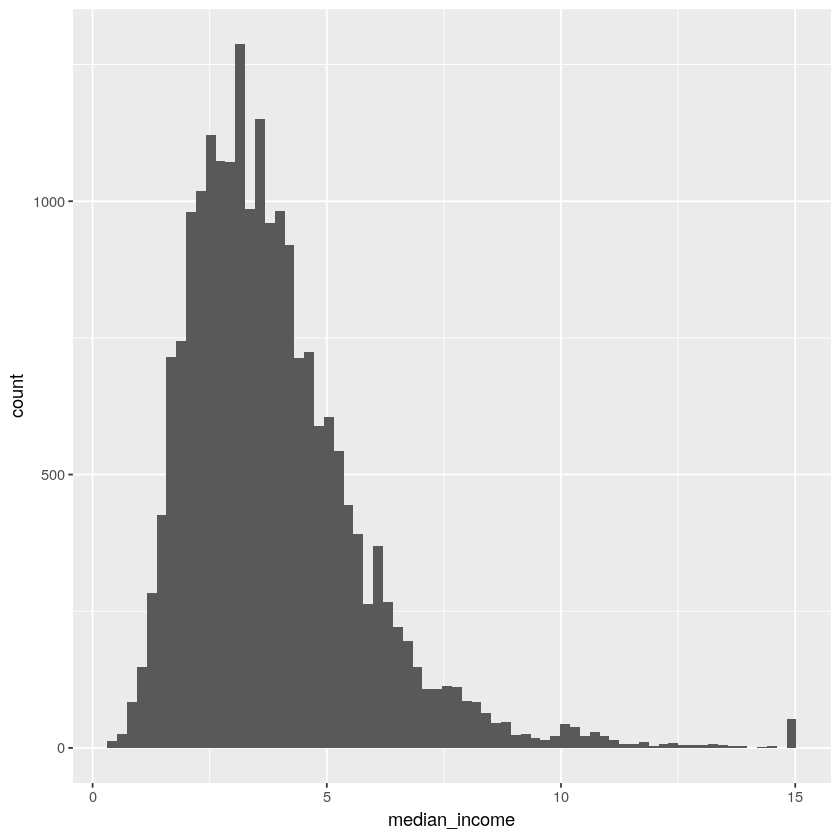

In [3]:
library(tidyverse)
housing_orig <- read.csv("_datasets/housing.csv") %>% as_tibble

housing_orig_long <- gather(housing_orig, what, value, longitude:median_house_value, factor_key=T)
ggplot(housing_orig) + geom_histogram(aes(x=median_income), bins=70)


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




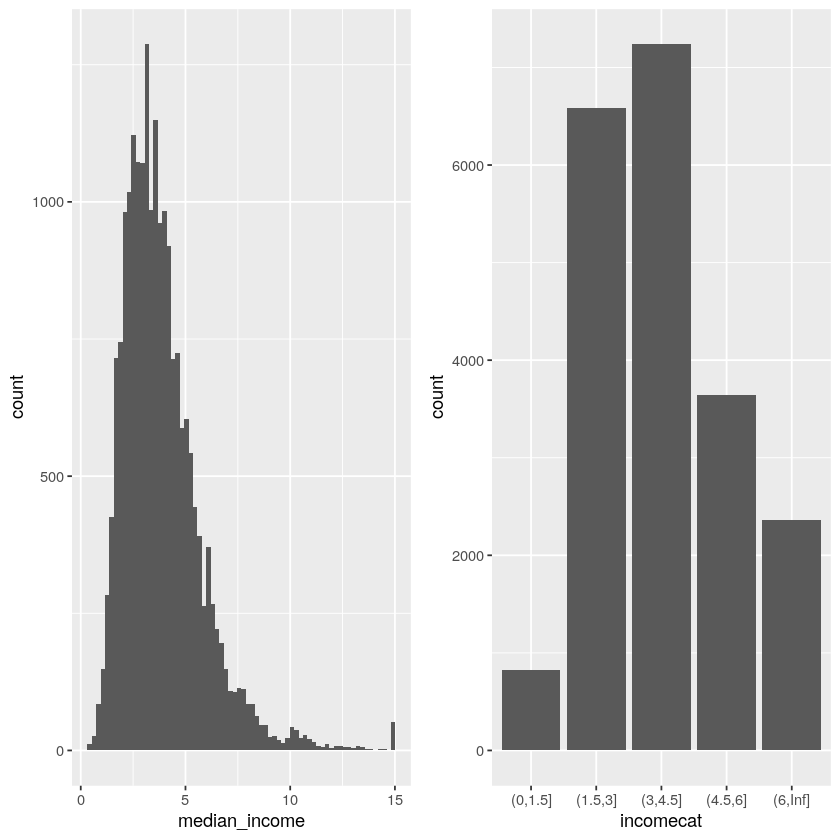

In [4]:
library(cowplot)
housing <- housing_orig %>%
  mutate(incomecat = cut(median_income, c(0, 1.5, 3, 4.5, 6, Inf)))

p1 <- ggplot(housing) + geom_histogram(aes(x=median_income), bins=70)
p2 <- ggplot(housing) + geom_bar(aes(x=incomecat))
plot_grid(p1, p2)
ggsave("assets/housing_income_as_category.png", height=6, width=12)

Saving 6.67 x 2 in image



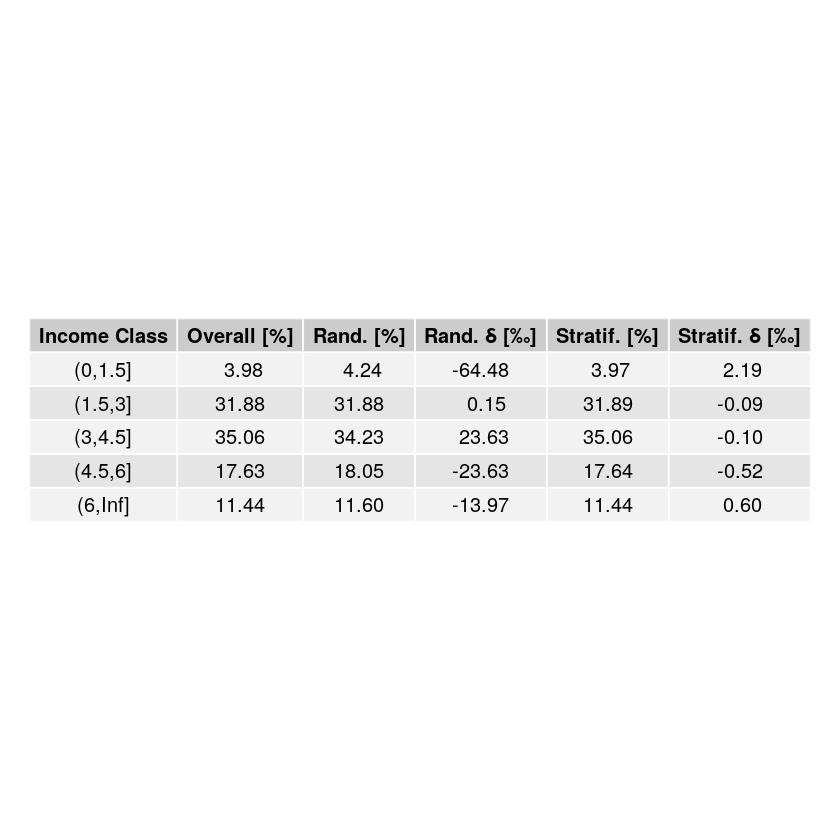

In [337]:
library(zeallot)
library(knitr)
shuffle_split_rng <- function(data, proportion, seed=NA) {
    if (! is.na(seed)) { set.seed(seed) }
    permutated_indices <- sample(nrow(data))
    num_of_elems_in_split <- floor(nrow(data) * proportion)
    split <- data[permutated_indices,][1:num_of_elems_in_split,]
    remainder <- data[permutated_indices,][(num_of_elems_in_split+1):nrow(data),]
    list(split, remainder)
}
shuffle_split_stratified <- function(data, proportion, seed=NA) {
    if (! is.na(seed)) { set.seed(seed) }
    dd <- data %>% mutate(rownum = row_number())
    split <- dd %>% group_by(incomecat) %>% sample_frac(proportion) %>% ungroup
    remainder <- dd %>% filter(! rownum %in% split$rownum ) %>% select(-rownum)
    list(split %>% select(-rownum), remainder)
}

c(split_rng, remainder_rng) %<-% shuffle_split_rng(housing, 0.2, seed=1)
c(split_stratified, remainder_stratified) %<-% shuffle_split_stratified(housing, 0.2, seed=1)

df <- housing %>% select(incomecat) %>% group_by(incomecat) %>%
        summarize(overall_freq=n()/nrow(housing) * 100) 
    
for (dfname in list("split_rng", "split_stratified")) {
    dd=get(dfname) # string to variable
    dftemp <- dd %>% select(incomecat) %>% group_by(incomecat) %>% summarize(rel_prevalence=100 * n()/nrow(dd))
    colname <- paste0(dfname,"_freq") 
    df[colname] <- dftemp$rel_prevalence
    df[paste0(colname,"_rel_error")] <- 1000 * (df$overall_freq - df[colname]) / df$overall_freq
}
df <- df %>% rapply(f = function(x) { round(x, 2) }, classes="numeric", how="replace")
names(df) <- c("Income Class", "Overall [%]", "Rand. [%]","Rand. δ [‰]","Stratif. [%]","Stratif. δ [‰]")

library(gridExtra)
plot_grid(tableGrob(df, rows=NULL), nrow=1)
ggsave("/tmp/muhtable.png", height=2)

In [315]:
set.seed(1)
dd <- housing %>% sample_n(100)
c(split, remainder) %<-% shuffle_split_stratified(dd, 0.2)
nrow(split)
nrow(remainder)

[1] 20

[1] 80

In [127]:
df[3:nrow(df),]

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,incomecat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,"(6,Inf]"
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,"(4.5,6]"
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,"(3,4.5]"
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY,"(3,4.5]"
-122.25,37.84,52,2535,489,1094,514,3.6591,299200,NEAR BAY,"(3,4.5]"
-122.25,37.84,52,3104,687,1157,647,3.1200,241400,NEAR BAY,"(3,4.5]"
-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,"(1.5,3]"
-122.25,37.84,52,3549,707,1551,714,3.6912,261100,NEAR BAY,"(3,4.5]"
